In [84]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

import gym
import mujoco_py
from gym import wrappers
from IPython import display
plt.rcParams["figure.figsize"] = (18,6)
%matplotlib inline

## Data Collection

In [85]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
"""
    Timestep for InvertedPendelum-v4 is 0.02
"""
obs, info = env.reset()
# ud = np.array([0])
# yd = obs
# done = False
# start = True

Tini = 1
n = 4
N = 25
m = 1
p = 4
T = (m+1)*(Tini + N + n) + 2
print(T)
render_collection = False

ud = []
yd = []

for i in range(T):
    action = env.action_space.sample()
    # action = np.random.randn(1,)
    # action = np.random.uniform(low=-0.5, high=0.5, size=(m,))
    obs, rew, done, info, _ = env.step(action)
    # if not start:
    #     obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
    # start = False

    if render_collection:
        plt.title(f"Action {action[0]:.3f} Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    ud = np.append(ud,action)
    yd = np.append(yd,obs)

env.close()
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

62
yd shape : (248,)   ud shape : (62,)


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [86]:
L = Tini + N + n
H = hankel(ud[0:L], ud[L-1:])
rank = np.linalg.matrix_rank(H)
print(f'H has rank {rank} and shape {H.shape}')
if rank != H.shape[0]:
    raise ValueError

H has rank 30 and shape (30, 33)


In [87]:
L = Tini + N

U = hankel(ud[0:L], ud[L-1:])

Y = np.zeros((L*p, T-L+1))
for i in range(0,T-L+1):
    Y[:,i] = yd[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

# u_ini = ud[:Tini]
# y_ini = yd[:p*Tini]
u_ini = np.array([0])
y_ini = np.array([0,0,0,0])
print(f'u ini : {u_ini}\ny ini : {y_ini}')


U = (26, 37), Up = (1, 37), Uf = (25, 37)
Y = (104, 37), Yp = (4, 37), Yf = (100, 37)
u ini : [0]
y ini : [0 0 0 0]


## Solver

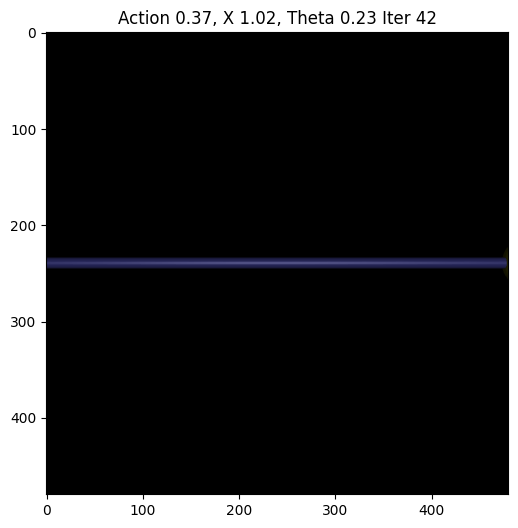

In [88]:
g = cp.Variable(T - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)
PI = np.vstack([Up, Yp, Uf])
PI = np.linalg.pinv(PI)@PI
# print(PI.shape)
I = np.eye(PI.shape[0])
PI = I - PI
# print(PI.shape)
# sig_y = cp.Variable(p*Tini)
y_r = np.zeros(p).reshape((p,))
A = np.vstack([Up,Yp,Uf,Yf])
A = np.linalg.pinv(A)
u_r = 0 # steady state control input
stacked_ref = np.hstack([
  np.kron(np.ones(Tini).reshape((Tini,)), u_r),
  np.kron(np.ones(Tini).reshape((Tini,)), y_r),
  np.kron(np.ones(N).reshape((N,)), u_r),
  np.kron(np.ones(N).reshape((N,)), y_r)
])

g_r = A @ stacked_ref

Q = np.diag([1,10,1,3])
Q_block = np.kron(np.eye(N-1), Q)
R = np.eye(N)*50

cost = cp.quad_form(y[-p:], 10*Q) + cp.quad_form(y[:-p], Q_block) + cp.quad_form(u,R) + cp.sum_squares(g-g_r)*500 + cp.norm(g, 1)*100

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
env._max_episode_steps = 50
obs = env.reset()
yT = [*y_ini]
uT = [*u_ini]
done = False
iter = 0
render_solution = True
y_const = np.kron(np.ones(N), np.array([10, 0.1, 10, 10]))
u_const = np.ones(N)*3

while not done:

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini,# + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= u_const,
    cp.abs(y) <= y_const
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.ECOS, verbose=False)
  # print(prob.variables()[1].value)
  action = prob.variables()[1].value[0]
  # print(prob._constraints)

  obs,_,done,_,_ = env.step([action])
  # obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
  yT = np.append(yT, obs)
  uT = np.append(uT, action)
  
  if render_solution:
    plt.title(f"Action {action:.2f}, X {obs[0]:.2f}, Theta {obs[1]:.2f} Iter {iter}")
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)

  u_ini = uT[-Tini:]
  y_ini = yT[-p*Tini:]
  iter += 1

In [89]:
print(prob._status)

optimal


In [90]:
g_r

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


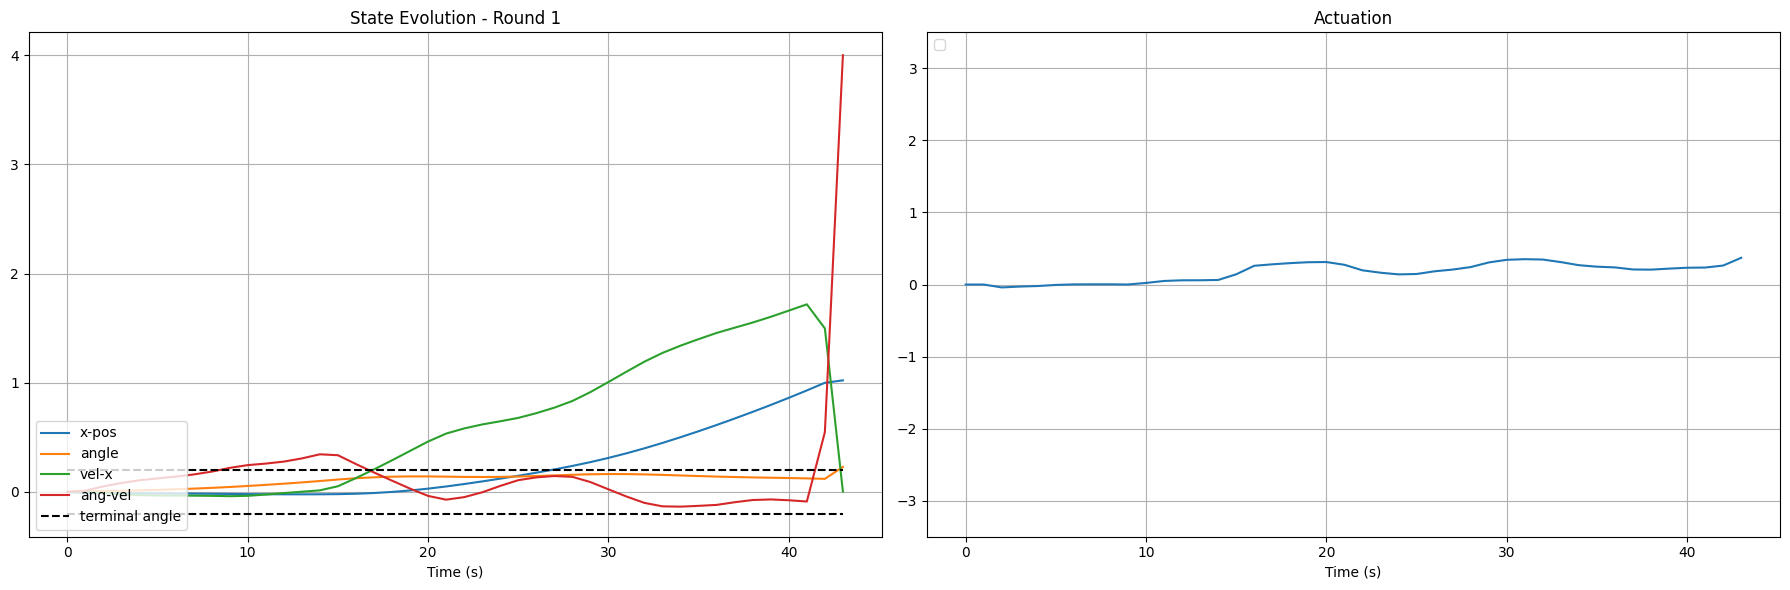

In [91]:
T = len(uT)
yT = yT.reshape((T,4))

plt.subplot(1,2,1)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='terminal angle')
plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
plt.legend(loc="lower left")
plt.xlabel('Time (s)')
plt.title("State Evolution - Round 1")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3.5,3.5))
plt.grid('on')
plt.tight_layout()

plt.show()

## Round 2

In [92]:
yd2 = yT
ud2 = uT
T2 = len(ud2)
yd2 = yd2.reshape((T2*p,))
print(f'yd shape : {yd2.shape}   ud shape : {ud2.shape}')


yd shape : (176,)   ud shape : (44,)


In [93]:
L = Tini + N + n
H = hankel(ud2[0:L], ud2[L-1:])
rank = np.linalg.matrix_rank(H)
print(f'H has rank {rank} and shape {H.shape}')
if rank != H.shape[0]:
    raise ValueError('hankel matrix is not full row rank')

H has rank 15 and shape (30, 15)


ValueError: hankel matrix is not full row rank

In [ ]:
L = Tini + N

U = hankel(ud2[0:L], ud2[L-1:])

Y = np.zeros((L*p, T2-L+1))
for i in range(0,T2-L+1):
    Y[:,i] = yd2[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = np.array([0])
y_ini = np.array([0,0,0,0])
print(f'u ini : {u_ini}\ny ini : {y_ini}')

U = (16, 28), Up = (1, 28), Uf = (15, 28)
Y = (64, 28), Yp = (4, 28), Yf = (60, 28)
u ini : [0]
y ini : [0 0 0 0]


In [ ]:
g = cp.Variable(T2 - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)
# sig_y = cp.Variable(p*Tini)

Q = np.diag([1,10,1,3])
Q = np.kron(np.eye(N), Q)
R = np.eye(N)*0.1

cost = cp.quad_form(y[-p:], 10*Q) + cp.quad_form(y[:-p], Q) + cp.quad_form(u,R) + cp.sum_squares(g)*500 #+ cp.norm(sig_y, 1)*10000

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
env._max_episode_steps = 50
obs = env.reset()
yT2 = [*y_ini]
uT2 = [*u_ini]
done = False
iter = 0
render_solution = False
y_const = np.kron(np.ones(N), np.array([2, 0.2, 2, 2]))
u_const = np.ones(N)*3

while not done:
  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini,# + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= u_const,
    cp.abs(y) <= y_const
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.ECOS, verbose=False)
  # print(prob.variables()[1].value)
  action = prob.variables()[1].value[0]
  # print(prob._constraints)

  if render_solution:
    plt.title(f"Action {action:.3f} Iter {iter}")
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)

  obs,_,done,_,_ = env.step([action])
  # obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
  yT2 = np.append(yT2, obs)
  uT2 = np.append(uT2, action)
  
  u_ini = uT2[-Tini:]
  y_ini = yT2[-p*Tini:]
  iter += 1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


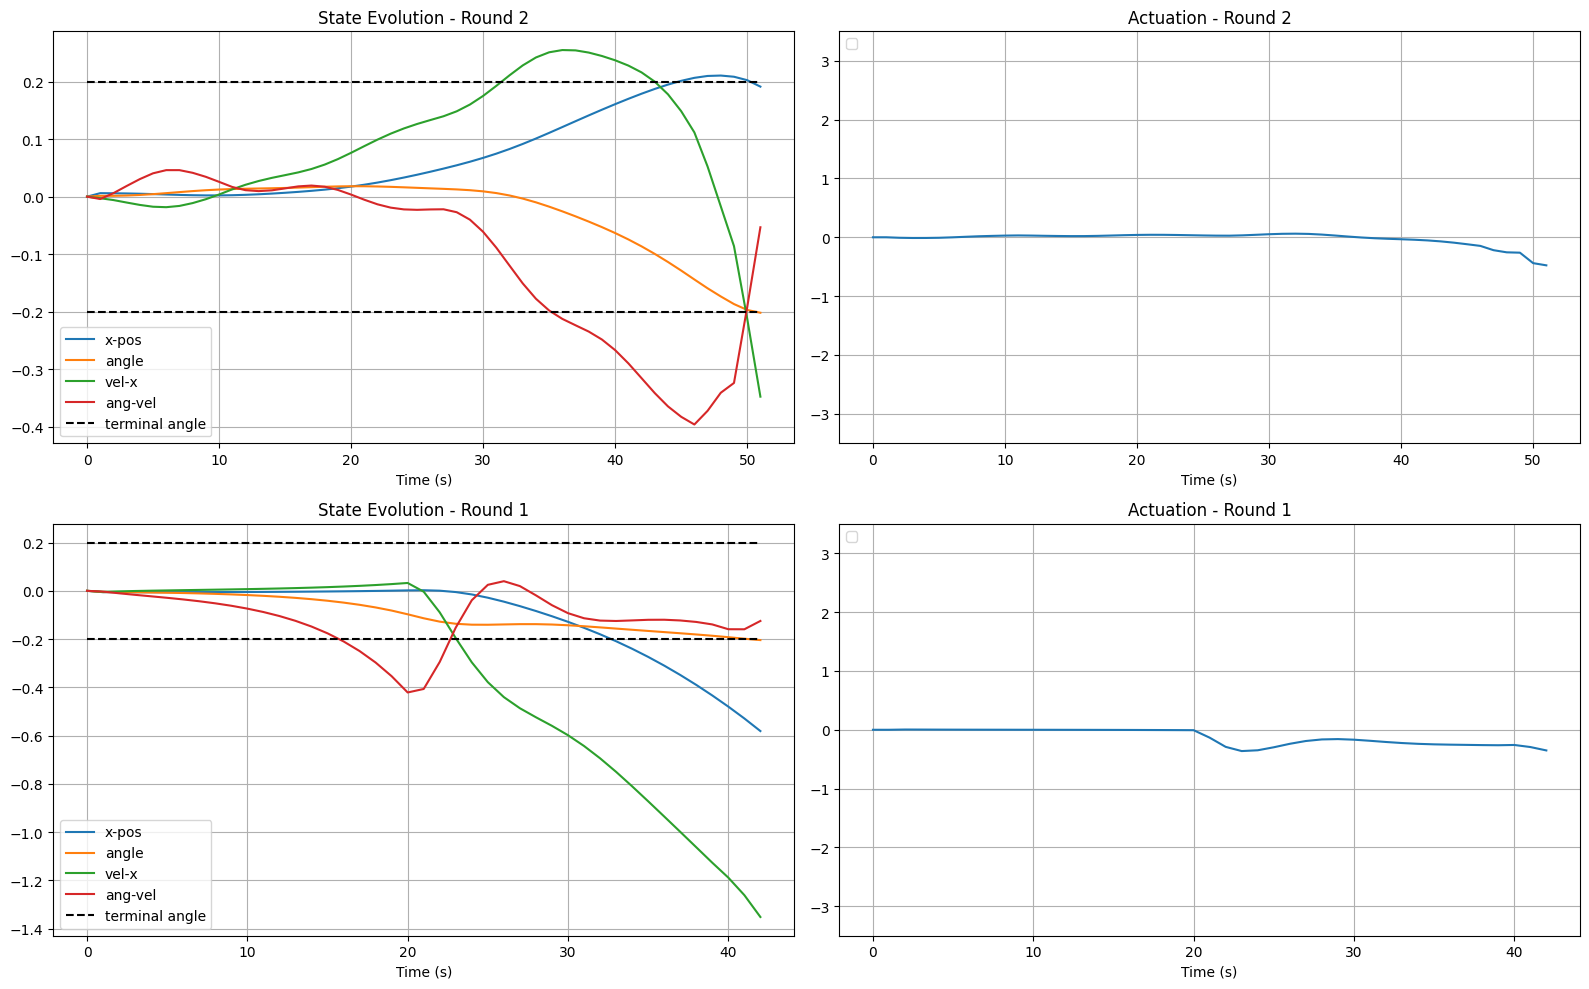

In [ ]:
T2 = len(uT2)
yT2 = yT2.reshape((T2,4))
T = len(uT)
yT = yT.reshape((T,4))
plt.rcParams["figure.figsize"] = (16,10)

plt.subplot(2,2,1)
plt.plot(range(0,T2), yT2, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.plot(range(0,T2), np.ones(T2)*0.2, 'k--',label='terminal angle')
plt.plot(range(0,T2), -np.ones(T2)*0.2, 'k--')
plt.legend(loc="lower left")
plt.xlabel('Time (s)')
plt.title("State Evolution - Round 2")
plt.grid('on')
plt.tight_layout()

plt.subplot(2,2,2)
plt.plot(range(0,T2), uT2)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation - Round 2")
plt.ylim((-3.5,3.5))
plt.grid('on')
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='terminal angle')
plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
plt.legend(loc="lower left")
plt.xlabel('Time (s)')
plt.title("State Evolution - Round 1")
plt.grid('on')
plt.tight_layout()

plt.subplot(2,2,4)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation - Round 1")
plt.ylim((-3.5,3.5))
plt.grid('on')
plt.tight_layout()

plt.show()